In [1]:
import jax #pip install jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax #pip install distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import jaxmarl
from jaxmarl.wrappers.baselines import LogWrapper
from jaxmarl.environments.overcooked import Overcooked, overcooked_layouts, layout_grid_to_dict
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer
from jaxmarl import make
import hydra #pip install hydra-core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt

### Added to modify the structure of the definitions
from functools import partial

In [2]:
### Added to save checkpoints
#import flax.serialization
from datetime import datetime
import pickle
import os
from pathlib import Path

In [3]:
custom_layout_grid = """
WWPWW
WA AW
B   X
W   W
WOWOW
"""
layout = layout_grid_to_dict(custom_layout_grid)

In [4]:
# Save checkpoint function
def save_checkpoint(checkpoint_state, seed_idx, step_idx, config):
    """Save a checkpoint to disk"""
    checkpoint_path = os.path.join(
        config["CHECKPOINT_DIR"], 
        f"checkpoints_seed{seed_idx}_step{step_idx}.pkl"
    )
    
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint_state, f)
    
    print(f"Saved checkpoint to {checkpoint_path}")

# Load checkpoint function
def load_checkpoint(seed_idx, step_idx, config):
    """Load a checkpoint from disk"""
    checkpoint_path = os.path.join(
        config["CHECKPOINT_DIR"], 
        f"checkpoints_seed{seed_idx}_step{step_idx}.pkl"
    )
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint {checkpoint_path} does not exist")
    
    with open(checkpoint_path, 'rb') as f:
        checkpoint_state = pickle.load(f)
    
    print(f"Loaded checkpoint from {checkpoint_path}")
    return checkpoint_state

In [5]:
class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"
    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu

        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)

class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


In [6]:
### MODIFICATIONS: Added this function to reshape the info dictionary

def reshape_info(info):
    def reshape_fn(x):
        if isinstance(x, dict):
            return jax.tree.map(lambda y: y.reshape(-1), x)
        # For (16, 2) shaped arrays, reshape to (32,)
        elif len(x.shape) == 2 and x.shape[1] == 2:
            return x.reshape(-1)
        # For (16,) shaped arrays
        else:
            # Repeat each element twice since we have 2 agents
            return jnp.repeat(x, 2)
    return jax.tree.map(reshape_fn, info)

In [7]:
def get_rollout(train_state, config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
    key = jax.random.PRNGKey(0)
    key, key_r, key_a = jax.random.split(key, 3)

    init_x = jnp.zeros(env.observation_space().shape)
    init_x = init_x.flatten()

    network.init(key_a, init_x)
    network_params = train_state.params

    done = False

    obs, state = env.reset(key_r)
    state_seq = [state]
    while not done:
        key, key_a0, key_a1, key_s = jax.random.split(key, 4)

        # obs_batch = batchify(obs, env.agents, config["NUM_ACTORS"])
        # breakpoint()
        obs = {k: v.flatten() for k, v in obs.items()}

        pi_0, _ = network.apply(network_params, obs["agent_0"])
        pi_1, _ = network.apply(network_params, obs["agent_1"])

        actions = {"agent_0": pi_0.sample(seed=key_a0), "agent_1": pi_1.sample(seed=key_a1)}
        # env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)
        # env_act = {k: v.flatten() for k, v in env_act.items()}

        # STEP ENV
        obs, state, reward, done, info = env.step(key_s, state, actions)
        done = done["__all__"]

        state_seq.append(state)

    return state_seq


In [8]:
def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))

def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

In [9]:
def linear_schedule(count, config):
    frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
    return config["LR"] * frac

In [10]:
def init_network(rng, env, network, config):
    rng, _rng = jax.random.split(rng)
    print(env.observation_space().shape)
    init_x = jnp.zeros(env.observation_space().shape)
    init_x = init_x.flatten()
    network_params = network.init(_rng, init_x)
    
    if config["ANNEAL_LR"]:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(learning_rate=lambda count: linear_schedule(count, config), eps=1e-5),
        )
    else:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), 
            optax.adam(config["LR"], eps=1e-5)
        )
    
    train_state = TrainState.create(
        apply_fn=network.apply,
        params=network_params,
        tx=tx,
    )
    
    return train_state, rng

In [11]:
#def init_environment(rng, env, config):
#    rng, _rng = jax.random.split(rng)
#    reset_rngs = []
#    for i in range(config["NUM_ENVS"]):
#        reset_rngs.append(jax.random.fold_in(_rng, i))
#    
#    observations = {agent: [] for agent in env.agents}
#    env_states_list = []
#
#    for i in range(config["NUM_ENVS"]):
#        obs, state = env.reset(reset_rngs[i])
#        for agent in env.agents:
#            observations[agent].append(obs[agent])
#        env_states_list.append(state)
#    
#    env_state = LogEnvState(
#    env_state=jax.tree.map(lambda x: jnp.stack([getattr(es.env_state, x) for es in env_states_list]), 
#                               env_states_list[0].env_state),
#        episode_returns=jnp.stack([es.episode_returns for es in env_states_list]),
#        episode_lengths=jnp.stack([es.episode_lengths for es in env_states_list]),
#        returned_episode_returns=jnp.stack([es.returned_episode_returns for es in env_states_list]),
#        returned_episode_lengths=jnp.stack([es.returned_episode_lengths for es in env_states_list])
#    )
#    return observations, env_state, rng

In [12]:
def select_action(train_state, network, observations, rng, env, config):
    rng, _rng = jax.random.split(rng)
    obs_batch = batchify(observations, env.agents, config["NUM_ACTORS"])
    pi, value = network.apply(train_state.params, obs_batch)
    action = pi.sample(seed=_rng)
    log_prob = pi.log_prob(action)
    env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)
    env_act = {k: v.flatten() for k, v in env_act.items()}
    
    return action, value, log_prob, env_act, rng

In [13]:
def step_environments(rng, env_states, env_actions, env, config):
    rng, _rng = jax.random.split(rng)
    new_observations = []
    new_env_states = []
    rewards = []
    dones = []
    infos = []
    
    for i in range(config["NUM_ENVS"]):
        rng_step = jax.random.fold_in(_rng, i)
        actions_for_env = {k: v[i] for k, v in env_actions.items()}
        obs, state, reward, done, info = env.step(rng_step, env_states[i], actions_for_env)
        new_observations.append(obs)
        new_env_states.append(state)
        rewards.append(reward)
        dones.append(done)
        infos.append(info)
    
    # Process info to avoid reshaping errors
    processed_info = reshape_info(infos)
    
    return new_observations, new_env_states, rewards, dones, processed_info, rng

In [14]:
def create_transition(observations, actions, values, rewards, log_probs, dones, info, env, config):
    obs_batch = batchify(observations, env.agents, config["NUM_ACTORS"])
    reward_batch = batchify(rewards, env.agents, config["NUM_ACTORS"]).squeeze()
    done_batch = batchify(dones, env.agents, config["NUM_ACTORS"]).squeeze()
    
    return Transition(
        done_batch,
        actions,
        values,
        reward_batch,
        log_probs,
        obs_batch,
        info
    )

In [15]:
def calculate_advantages_and_targets(traj_batch, last_val, config):
    advantages = jnp.zeros_like(last_val)
    next_value = last_val
    
    for t in reversed(range(len(traj_batch.reward))):
        done = traj_batch.done[t]
        reward = traj_batch.reward[t]
        value = traj_batch.value[t]
        
        delta = reward + config["GAMMA"] * next_value * (1 - done) - value
        advantages = delta + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * advantages
        next_value = value
    
    targets = advantages + traj_batch.value
    return advantages, targets

In [16]:
def compute_loss(params, network, traj_batch, advantages, targets, config):
    # RERUN NETWORK
    pi, value = network.apply(params, traj_batch.obs)
    log_prob = pi.log_prob(traj_batch.action)

    # CALCULATE VALUE LOSS
    value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
    value_losses = jnp.square(value - targets)
    value_losses_clipped = jnp.square(value_pred_clipped - targets)
    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

    # CALCULATE ACTOR LOSS
    ratio = jnp.exp(log_prob - traj_batch.log_prob)
    normalized_advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    loss_actor1 = ratio * normalized_advantages
    loss_actor2 = jnp.clip(ratio, 1.0 - config["CLIP_EPS"], 1.0 + config["CLIP_EPS"]) * normalized_advantages
    loss_actor = -jnp.minimum(loss_actor1, loss_actor2).mean()
    entropy = pi.entropy().mean()

    total_loss = (
        loss_actor
        + config["VF_COEF"] * value_loss
        - config["ENT_COEF"] * entropy
    )
    return total_loss, (value_loss, loss_actor, entropy)


In [17]:
def update_network(train_state, traj_batch, advantages, targets, rng, network, config):
    rng, _rng = jax.random.split(rng)
    batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
    
    # Reshape batch data
    flat_traj = jax.tree_util.tree_map(
        lambda x: x.reshape((batch_size,) + x.shape[2:]),
        (traj_batch, advantages, targets)
    )
    
    # Shuffle data
    permutation = jax.random.permutation(_rng, batch_size)
    shuffled_traj, shuffled_advantages, shuffled_targets = jax.tree_util.tree_map(
        lambda x: jnp.take(x, permutation, axis=0),
        flat_traj
    )
    
    # Split into minibatches
    minibatches = []
    for i in range(config["NUM_MINIBATCHES"]):
        start_idx = i * config["MINIBATCH_SIZE"]
        end_idx = (i + 1) * config["MINIBATCH_SIZE"]
        
        minibatch_traj = jax.tree_util.tree_map(
            lambda x: x[start_idx:end_idx],
            shuffled_traj
        )
        minibatch_advantages = shuffled_advantages[start_idx:end_idx]
        minibatch_targets = shuffled_targets[start_idx:end_idx]
        
        minibatches.append((minibatch_traj, minibatch_advantages, minibatch_targets))
    
    # Update for each minibatch
    total_losses = []
    for epoch in range(config["UPDATE_EPOCHS"]):
        for minibatch_traj, minibatch_advantages, minibatch_targets in minibatches:
            grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
            (total_loss, aux), grads = grad_fn(
                train_state.params, network, minibatch_traj, minibatch_advantages, minibatch_targets, config
            )
            train_state = train_state.apply_gradients(grads=grads)
            total_losses.append(total_loss)
    
    return train_state, total_losses, rng

In [18]:
def collect_trajectories(train_state, env_states, observations, rng, env, network, config):
    trajectories = []
    
    for step in range(config["NUM_STEPS"]):
        # SELECT ACTION
        actions, values, log_probs, env_actions, rng = select_action(
            train_state, network, observations, rng, env, config
        )
        
        # STEP ENVIRONMENT
        new_observations, new_env_states, rewards, dones, info, rng = step_environments(
            rng, env_states, env_actions, env, config
        )
        
        # CREATE TRANSITION
        transition = create_transition(
            observations, actions, values, rewards, log_probs, dones, info, env, config
        )
        
        trajectories.append(transition)
        observations = new_observations
        env_states = new_env_states
    
    # Convert list of transitions to a batched structure
    traj_batch = jax.tree_util.tree_map(
        lambda *xs: jnp.stack(xs),
        *trajectories
    )
    
    return traj_batch, env_states, observations, rng

In [19]:
def create_train_function(env, config):
    def train(rng):
        # Initialize network
        network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
        train_state, rng = init_network(rng, env, network, config)
        
        # Initialize environment
        #observations, env_states, rng = init_environment(rng, env, config)
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        observations, env_states = jax.vmap(env.reset, in_axes=(0,))(reset_rng)
        
        metrics = []
        
        # Training loop
        for update in range(config["NUM_UPDATES"]):
            # Collect trajectories
            traj_batch, env_states, observations, rng = collect_trajectories(
                train_state, env_states, observations, rng, env, network, config
            )
            
            # Get last value for advantage calculation
            obs_batch = batchify(observations, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, obs_batch)
            
            # Calculate advantages and targets
            advantages, targets = calculate_advantages_and_targets(traj_batch, last_val, config)
            
            # Update network
            train_state, losses, rng = update_network(
                train_state, traj_batch, advantages, targets, rng, network, config
            )
            
            metrics.append(traj_batch.info)
        
        return {
            "runner_state": (train_state, env_states, observations, rng),
            "metrics": jnp.stack(metrics)
        }
    
    return train

In [20]:
def make_train(config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    print(f'NUM_ENVS: {config["NUM_ENVS"]}')
    print(f'NUM_STEPS: {config["NUM_STEPS"]}')
    print(f'TOTAL_TIMESTEPS: {config["TOTAL_TIMESTEPS"]}')
    print(f'NUM_MINIBATCHES: {config["NUM_MINIBATCHES"]}')

    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    print(f'NUM_ACTORS: {config["NUM_ACTORS"]}')

    config["NUM_UPDATES"] = int(
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    print(f'NUM_UPDATES: {config["NUM_UPDATES"]}')

    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    print(f'MINIBATCH_SIZE: {config["MINIBATCH_SIZE"]}')
    
    env = LogWrapper(env)

    return create_train_function(env, config)

In [21]:
# Modified train function to save checkpoints at each iteration
def train_fn_with_checkpointing(seed_rng, config, seed_idx):
    # Create training function
    train_fn = make_train(config)
    
    # Create a custom iterator for training steps
    def custom_training_loop(rng):
        # Initialize network
        env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])
        env = LogWrapper(env)
        network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
        
        # Initialize network and state
        train_state, rng = init_network(rng, env, network, config)
        #observations, env_states, rng = init_environment(rng, env, config)
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        observations, env_states = jax.vmap(env.reset, in_axes=(0,))(reset_rng)
        
        metrics = []
        
        # Training loop with checkpoints at each step
        for update in range(config["NUM_UPDATES"]):
            print(f"Seed {seed_idx+1}, Update {update+1}/{config['NUM_UPDATES']}")
            
            # Collect trajectories
            traj_batch, env_states, observations, rng = collect_trajectories(
                train_state, env_states, observations, rng, env, network, config
            )
            
            # Get last value for advantage calculation
            obs_batch = batchify(observations, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, obs_batch)
            
            # Calculate advantages and targets
            advantages, targets = calculate_advantages_and_targets(traj_batch, last_val, config)
            
            # Update network
            train_state, losses, rng = update_network(
                train_state, traj_batch, advantages, targets, rng, network, config
            )
            
            metrics.append(traj_batch.info)
            
            # Save checkpoint at current iteration
            checkpoint_state = {
                "train_state": train_state,
                "env_states": env_states,
                "observations": observations,
                "rng": rng,
                "metrics": metrics,
                "update_idx": update,
                "seed_idx": seed_idx,
                "config": config
            }
            
            save_checkpoint(checkpoint_state, seed_idx, update, config)
        
        return {
            "runner_state": (train_state, env_states, observations, rng),
            "metrics": jnp.stack(metrics)
        }
    
    # Run the custom training loop
    result = custom_training_loop(seed_rng)
    return result

In [22]:
# Train function using individual seeds
def train_with_seeds(config):
    # Initialize random seeds
    master_rng = jax.random.PRNGKey(config["SEED"])
    seed_rngs = jax.random.split(master_rng, config["NUM_SEEDS"])
    
    # Train for each seed
    all_outputs = []
    
    for seed_idx in range(config["NUM_SEEDS"]):
        print(f"Training with seed {seed_idx + 1}/{config['NUM_SEEDS']}")
        
        # Run training with checkpointing
        with jax.disable_jit(False):  # Optional, depends on debugging needs
            output = train_fn_with_checkpointing(seed_rngs[seed_idx], config, seed_idx)
        
        all_outputs.append(output)
    
    return all_outputs

In [23]:
# Plotting function
def plot_training_results(outputs, config):
    plt.figure(figsize=(10, 6))
    
    for seed_idx in range(config["NUM_SEEDS"]):
        # Extract metrics - adjust the key path based on your metrics structure
        returns = outputs[seed_idx]["metrics"]["returned_episode_returns"].mean(-1).reshape(-1)
        plt.plot(returns, label=f"Seed {seed_idx}")
    
    plt.xlabel("Update Step")
    plt.ylabel("Return")
    plt.title("Training Performance Across Seeds")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [24]:
# Set hyperparameters
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 5e6,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "overcooked",
    "ENV_KWARGS": {
      "layout" : "cramped_room"
    },
    "ANNEAL_LR": True,
    "SEED": 0,
    "NUM_SEEDS": 3,
    "CHECKPOINT_FREQ": 1,  # Save on every iteration
    "CHECKPOINT_DIR": "C:/OneDrive - Universidad Complutense de Madrid (UCM)/Doctorado/JaxMARL/SAMUEL_LOZANO/Checkpoints"  # Directory to save checkpoints
}

# Set the layout
config["ENV_KWARGS"]["layout"] = overcooked_layouts[config["ENV_KWARGS"]["layout"]]

# Ensure checkpoint directory exists
Path(config["CHECKPOINT_DIR"]).mkdir(parents=True, exist_ok=True)

# Run the training
outputs = train_with_seeds(config)

# Plot the results
plot_training_results(outputs, config)

Training with seed 1/3
NUM_ENVS: 16
NUM_STEPS: 128
TOTAL_TIMESTEPS: 5000000.0
NUM_MINIBATCHES: 4
NUM_ACTORS: 32
NUM_UPDATES: 2441
MINIBATCH_SIZE: 1024
(5, 4, 26)
Seed 1, Update 1/2441


TypeError: 'LogEnvState' object is not subscriptable

In [ ]:
# Function to resume training from a checkpoint
def resume_from_checkpoint(seed_idx, step_idx, config, num_additional_steps=None):
    # Load the checkpoint
    checkpoint_state = load_checkpoint(seed_idx, step_idx, config)
    
    # Extract state
    train_state = checkpoint_state["train_state"]
    env_states = checkpoint_state["env_states"]
    observations = checkpoint_state["observations"]
    rng = checkpoint_state["rng"]
    metrics = checkpoint_state["metrics"]
    
    # Set up environment and network
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    env = LogWrapper(env)
    network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
    
    # Determine how many more steps to run
    start_update = step_idx + 1
    if num_additional_steps is None:
        end_update = config["NUM_UPDATES"]
    else:
        end_update = start_update + num_additional_steps
    
    # Continue training loop
    for update in range(start_update, end_update):
        print(f"Seed {seed_idx+1}, Update {update+1}/{end_update} (resumed)")
        
        # Collect trajectories
        traj_batch, env_states, observations, rng = collect_trajectories(
            train_state, env_states, observations, rng, env, network, config
        )
        
        # Get last value for advantage calculation
        obs_batch = batchify(observations, env.agents, config["NUM_ACTORS"])
        _, last_val = network.apply(train_state.params, obs_batch)
        
        # Calculate advantages and targets
        advantages, targets = calculate_advantages_and_targets(traj_batch, last_val, config)
        
        # Update network
        train_state, losses, rng = update_network(
            train_state, traj_batch, advantages, targets, rng, network, config
        )
        
        metrics.append(traj_batch.info)
        
        # Save checkpoint at current iteration
        checkpoint_state = {
            "train_state": train_state,
            "env_states": env_states,
            "observations": observations,
            "rng": rng,
            "metrics": metrics,
            "update_idx": update,
            "seed_idx": seed_idx,
            "config": config
        }
        
        save_checkpoint(checkpoint_state, seed_idx, update, config)
    
    # Return the final state
    return {
        "runner_state": (train_state, env_states, observations, rng),
        "metrics": jnp.stack(metrics)
    }

TrainState(step=Array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of ActorCritic(
    # attributes
    action_dim = 6
    activation = 'tanh'
)>, params={'params': {'Dense_0': {'bias': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ...,

In [142]:
def make_train(config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    print(f'NUM_ACTORS: {config["NUM_ACTORS"]}')
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    print(f'NUM_UPDATES: {config["NUM_UPDATES"]}')
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    print(f'NUM_MINIBATCHES: {config["NUM_MINIBATCHES"]}')
    print(f'MINIBATCH_SIZE: {config["MINIBATCH_SIZE"]}')

    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        print(env.observation_space().shape)
        init_x = jnp.zeros(env.observation_space().shape)

        init_x = init_x.flatten()

        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0,))(reset_rng)
        print(env_state)
        print(type(env_state))
        
        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                print(last_obs)
                print(type(last_obs))
                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])

                pi, value = network.apply(train_state.params, obs_batch)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)

                env_act = {k:v.flatten() for k,v in env_act.items()}

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0))(
                    rng_step, env_state, env_act
                )
                
                ### MODIFICATIONS: I have changed the following line for the reshape_info one to avoid the TypeError: cannot reshape array of shape (16,) (size 16) into shape 32 (size 32)
                # info = jax.tree.map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
            
                info = reshape_info(info)

                transition = Transition(
                    batchify(done, env.agents, config["NUM_ACTORS"]).squeeze(),
                    action,
                    value,
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob,
                    obs_batch,
                    info

                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, last_obs_batch)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ACTORS"]
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, jnp.arange(config["NUM_UPDATES"])
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train

NUM_ACTORS: 32
NUM_UPDATES: 24.0
NUM_MINIBATCHES: 4
MINIBATCH_SIZE: 1024
(5, 4, 26)
LogEnvState(env_state=State(agent_pos=Traced<ShapedArray(uint32[16,2,2])>with<BatchTrace> with
  val = Traced<ShapedArray(uint32[3,16,2,2])>with<DynamicJaxprTrace>
  batch_dim = 0, agent_dir=Traced<ShapedArray(int8[16,2,2])>with<BatchTrace> with
  val = Traced<ShapedArray(int8[3,16,2,2])>with<DynamicJaxprTrace>
  batch_dim = 0, agent_dir_idx=Traced<ShapedArray(int32[16,2])>with<BatchTrace> with
  val = Traced<ShapedArray(int32[3,16,2])>with<DynamicJaxprTrace>
  batch_dim = 0, agent_inv=Traced<ShapedArray(int32[16,2])>with<BatchTrace> with
  val = Traced<ShapedArray(int32[3,16,2])>with<DynamicJaxprTrace>
  batch_dim = 0, goal_pos=Traced<ShapedArray(uint32[16,1,2])>with<DynamicJaxprTrace>, pot_pos=Traced<ShapedArray(uint32[16,1,2])>with<DynamicJaxprTrace>, wall_map=Traced<ShapedArray(bool[16,4,5])>with<DynamicJaxprTrace>, maze_map=Traced<ShapedArray(uint8[16,12,13,3])>with<BatchTrace> with
  val = Traced<

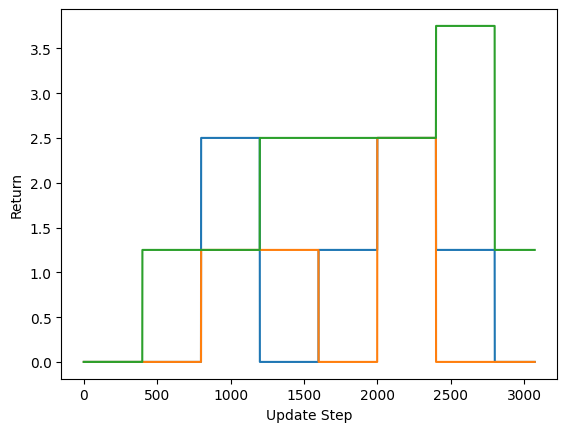

In [143]:
%matplotlib inline

# set hyperparameters:
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 5e4,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "overcooked",
    "ENV_KWARGS": {
      "layout" : "cramped_room"
    },
    "ANNEAL_LR": True,
    "SEED": 0,
    "NUM_SEEDS": 3
}

config["ENV_KWARGS"]["layout"] = overcooked_layouts[config["ENV_KWARGS"]["layout"]]
rng = jax.random.PRNGKey(config["SEED"])
rngs = jax.random.split(rng, config["NUM_SEEDS"])
with jax.disable_jit(False):
    train_jit = jax.jit(jax.vmap(make_train(config)))
    out = train_jit(rngs)


for i in range(config["NUM_SEEDS"]):
    plt.plot(out["metrics"]["returned_episode_returns"][i].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()